In [1]:
# add path to sispeuede to sys.path in python
import sys
import pathlib
import warnings
warnings.filterwarnings("ignore")


path_git = pathlib.Path("/Users/usuario/git")
for subdir in [
    "sisepuede", 
    "sisepuede_data_pipeline",
    # "sisepuede_juypyter"
]:
    path_cur = path_git.joinpath(subdir)
    if str(path_cur) not in sys.path:
        sys.path.append(str(path_cur))

path_pipeline = path_git.joinpath("sisepuede_data_pipeline")


import importlib
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import sisepuede.legacy.data_api as api
import sisepuede.manager.sisepuede_examples as sxl
import sisepuede.manager.sisepuede_file_structure as sfs
import sisepuede.manager.sisepuede_models as sm
import sisepuede.visualization.plots as svp
import sisepuede.utilities._plotting as spu
import sisepuede.core.support_classes as sc
import sisepuede.utilities._toolbox as sf
import time

from sisepuede.core.attribute_table import *
from typing import *


import lib.process_utilities as pu
import lib.sisepuede_data_constructs as dc
import lib._util as lutil




In [7]:
### SETUP DIRECTORIES

path_cur = pathlib.Path(os.getcwd())
path_data = path_cur.joinpath("data")
path_transformations = path_cur.joinpath("transformations")
#path_attr_tp = path_transformations.joinpath("attribute_dim_time_period.csv")

##  SETUP FILES




##  SETUP SOME PIPELINE STUFF

# get the time period
#attr_time_period = AttributeTable(path_attr_tp, "time_period")
file_struct = sfs.SISEPUEDEFileStructure()

# assign some shortcuts
matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)


##  SOME GLOBALS

_REGION_NAME = "libya"
_REGION_ISO = regions.return_region_or_iso(_REGION_NAME, return_type = "iso", )

path_data_built = pathlib.Path(
    os.path.abspath(f"./input_dat_libya.csv")
    #os.path.abspath(f"../generic_regions/data/output/sisepuede_raw_inputs_latest_{_REGION_ISO}.csv")
)

In [5]:
models = sm.SISEPUEDEModels(
    matt, 
    fp_julia = file_struct.dir_jl,
    fp_nemomod_reference_files = file_struct.dir_ref_nemo,
)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   1528.1 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.


In [58]:
df_libya = pd.read_csv(path_data_built, )
df_libya[regions.key] = _REGION_NAME


In [59]:
import sisepuede.transformers as trf
import sisepuede.transformers.transformations as tmts
importlib.reload(tmts.trs.tbe)
importlib.reload(tmts.trs)

# initialize a transformations set
if not path_transformations.is_dir():
    trf.instantiate_default_strategy_directory(
        transformers,
        path_transformations,
    )




transformations = tmts.Transformations(
    path_transformations,
    df_input = df_libya,
)
transformers = transformations.transformers

strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)







In [15]:
trfr = transformations.get_transformation("TX:BASE")
df = trfr()

df[[x for x in df.columns if "min_share_" in x]].iloc[-1]

nemomod_entc_frac_min_share_production_pp_biomass                     0.000000
nemomod_entc_frac_min_share_production_pp_coal                        0.000000
nemomod_entc_frac_min_share_production_pp_gas                         0.640546
nemomod_entc_frac_min_share_production_pp_geothermal                  0.000000
nemomod_entc_frac_min_share_production_pp_hydropower                  0.000000
nemomod_entc_frac_min_share_production_pp_nuclear                     0.000000
nemomod_entc_frac_min_share_production_pp_ocean                       0.000000
nemomod_entc_frac_min_share_production_pp_oil                         0.245617
nemomod_entc_frac_min_share_production_pp_solar                       0.110280
nemomod_entc_frac_min_share_production_pp_wind                        0.000000
nemomod_entc_frac_min_share_production_pp_biogas                      0.000000
nemomod_entc_frac_min_share_production_pp_coal_ccs                    0.000000
nemomod_entc_frac_min_share_production_pp_gas_ccs   

In [21]:
[x for x in dir(models.model_enerprod) if "target" in x]


['format_nemomod_table_re_min_production_target',
 'modvar_enfu_nemomod_renewable_production_target']

In [25]:
import sisepuede.transformers as trf
import sisepuede.transformers.transformations as tmts
importlib.reload(tmts.trs.tbe)
importlib.reload(tmts.trs)
transformations = tmts.Transformations(
    path_transformations,
    df_input = df_libya,
)

trfr = transformations.get_transformation("TX:ENTC:TARGET_RENEWABLE_ELEC_STRATEGY_NDC")
df = trfr()

df[[x for x in df.columns if "min_share_" in x]].iloc[-1]

nemomod_entc_frac_min_share_production_pp_biomass                     0.000000
nemomod_entc_frac_min_share_production_pp_coal                        0.000000
nemomod_entc_frac_min_share_production_pp_gas                         0.361415
nemomod_entc_frac_min_share_production_pp_geothermal                  0.050000
nemomod_entc_frac_min_share_production_pp_hydropower                  0.000000
nemomod_entc_frac_min_share_production_pp_nuclear                     0.000000
nemomod_entc_frac_min_share_production_pp_ocean                       0.000000
nemomod_entc_frac_min_share_production_pp_oil                         0.138585
nemomod_entc_frac_min_share_production_pp_solar                       0.110280
nemomod_entc_frac_min_share_production_pp_wind                        0.100000
nemomod_entc_frac_min_share_production_pp_biogas                      0.000000
nemomod_entc_frac_min_share_production_pp_coal_ccs                    0.000000
nemomod_entc_frac_min_share_production_pp_gas_ccs   

In [68]:
strat0 = strategies.get_strategy(0)
df0 = strat0().copy()

df0["nemomod_entc_scalar_availability_factor_pp_hydropower"] = 0.0
df0["nemomod_entc_scalar_availability_factor_pp_nuclear"] = 0.0
df_out_0 = models(
    df0, 
    include_electricity_in_energy = True, 
    time_periods_base = range(12),
    #time_periods_run = range(11),
)

2025-05-Nov 00:05:14.059 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-05-Nov 00:05:14.123 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-05-Nov 00:05:25.803 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-05-Nov 00:05:25.838 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-05-Nov 00:06:05.703 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


In [69]:
df_out_0[flds].tail()

,emission_co2e_ch4_fgtv_fuel_coal,emission_co2e_ch4_fgtv_fuel_natural_gas,emission_co2e_ch4_fgtv_fuel_oil,emission_co2e_co2_fgtv_fuel_coal,emission_co2e_co2_fgtv_fuel_natural_gas,emission_co2e_co2_fgtv_fuel_oil,emission_co2e_n2o_fgtv_fuel_coal,emission_co2e_n2o_fgtv_fuel_natural_gas,emission_co2e_n2o_fgtv_fuel_oil,emission_co2e_subsector_total_fgtv
31,0.287472,4.593887,0.068693,0.006796,2.055051,0.001999,0.0,0.000532,0.000004,7.014434
32,0.285760,4.612984,0.069130,0.006755,2.063179,0.002012,0.0,0.000534,0.000004,7.040357
33,0.284059,4.632032,0.069557,0.006715,2.071285,0.002024,0.0,0.000536,0.000004,7.066213
34,0.282377,4.651640,0.069989,0.006675,2.079634,0.002037,0.0,0.000538,0.000004,7.092895
35,0.280713,4.671856,0.070430,0.006636,2.088246,0.002050,0.0,0.000540,0.000004,7.120476


In [60]:
strat6003 = strategies.get_strategy(6003)
df6003 = strat6003().copy()

df6003["nemomod_entc_scalar_availability_factor_pp_hydropower"] = 0.0
df6003["nemomod_entc_scalar_availability_factor_pp_nuclear"] = 0.0
df_out = models(
    df6003, 
    include_electricity_in_energy = True, 
    time_periods_base = range(12),
    #time_periods_run = range(11),
)

2025-04-Nov 23:59:42.531 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-04-Nov 23:59:42.617 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-04-Nov 23:59:53.514 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-04-Nov 23:59:53.546 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-05-Nov 00:00:37.265 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


In [65]:
strat6004 = strategies.get_strategy(6004)
df6004 = strat6004().copy()

df6004["nemomod_entc_scalar_availability_factor_pp_hydropower"] = 0.0
df6004["nemomod_entc_scalar_availability_factor_pp_nuclear"] = 0.0
df_out_6004 = models(
    df6004, 
    include_electricity_in_energy = True, 
    time_periods_base = range(12),
    #time_periods_run = range(11),
)

2025-05-Nov 00:02:53.860 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-05-Nov 00:02:53.926 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-05-Nov 00:03:04.303 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-05-Nov 00:03:04.343 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-05-Nov 00:03:46.271 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


In [80]:
df_out_6004["prod_enfu_fuel_natural_gas_pj"]

0     1137.209763
1      983.521408
2      819.130231
3      858.112761
4      948.243152
5      854.825391
6      892.696989
7      867.926346
8      897.612322
9      925.533726
10     951.771444
11     968.397365
12     976.669438
13     985.390847
14     990.213596
15     990.267101
16     987.191428
17     981.332191
18     972.720190
19     961.445417
20     947.711036
21     931.784371
22     914.178155
23     895.298572
24     875.700772
25     855.804585
26     835.642644
27     815.490804
28     795.578256
29     776.115693
30     757.939758
31     769.329145
32     801.713208
33     834.154235
34     866.653522
35     899.208761
Name: prod_enfu_fuel_natural_gas_pj, dtype: float64

In [66]:
flds = [x for x in df_out.columns if ("emission_co2e" in x) and ("fgtv" in x)]
df_out[flds].tail()

,emission_co2e_ch4_fgtv_fuel_coal,emission_co2e_ch4_fgtv_fuel_natural_gas,emission_co2e_ch4_fgtv_fuel_oil,emission_co2e_co2_fgtv_fuel_coal,emission_co2e_co2_fgtv_fuel_natural_gas,emission_co2e_co2_fgtv_fuel_oil,emission_co2e_n2o_fgtv_fuel_coal,emission_co2e_n2o_fgtv_fuel_natural_gas,emission_co2e_n2o_fgtv_fuel_oil,emission_co2e_subsector_total_fgtv
31,0.884008,2.886638,0.029352,0.066838,1.449298,0.001699,0.0,0.000541,0.000006,5.318381
32,0.897191,2.795550,0.028842,0.071316,1.413908,0.001737,0.0,0.000540,0.000006,5.209091
33,0.908757,2.703397,0.028325,0.075913,1.377736,0.001775,0.0,0.000539,0.000006,5.096449
34,0.918871,2.610594,0.027805,0.080638,1.340962,0.001814,0.0,0.000538,0.000006,4.981228
35,0.927560,2.517260,0.027283,0.085492,1.303632,0.001853,0.0,0.000536,0.000006,4.863623


In [67]:
df_out_6004[flds].tail()


,emission_co2e_ch4_fgtv_fuel_coal,emission_co2e_ch4_fgtv_fuel_natural_gas,emission_co2e_ch4_fgtv_fuel_oil,emission_co2e_co2_fgtv_fuel_coal,emission_co2e_co2_fgtv_fuel_natural_gas,emission_co2e_co2_fgtv_fuel_oil,emission_co2e_n2o_fgtv_fuel_coal,emission_co2e_n2o_fgtv_fuel_natural_gas,emission_co2e_n2o_fgtv_fuel_oil,emission_co2e_subsector_total_fgtv
31,0.055019,0.781647,0.005978,0.014270,0.545793,0.000931,0.0,0.000365,0.000004,1.404006
32,0.047981,0.730971,0.005047,0.014261,0.521485,0.000889,0.0,0.000380,0.000004,1.321017
33,0.041366,0.673679,0.004189,0.014218,0.493390,0.000842,0.0,0.000395,0.000003,1.228083
34,0.035164,0.609748,0.003404,0.014143,0.461501,0.000792,0.0,0.000411,0.000003,1.125166
35,0.029364,0.539152,0.002693,0.014037,0.425804,0.000739,0.0,0.000426,0.000003,1.012218


<Axes: >

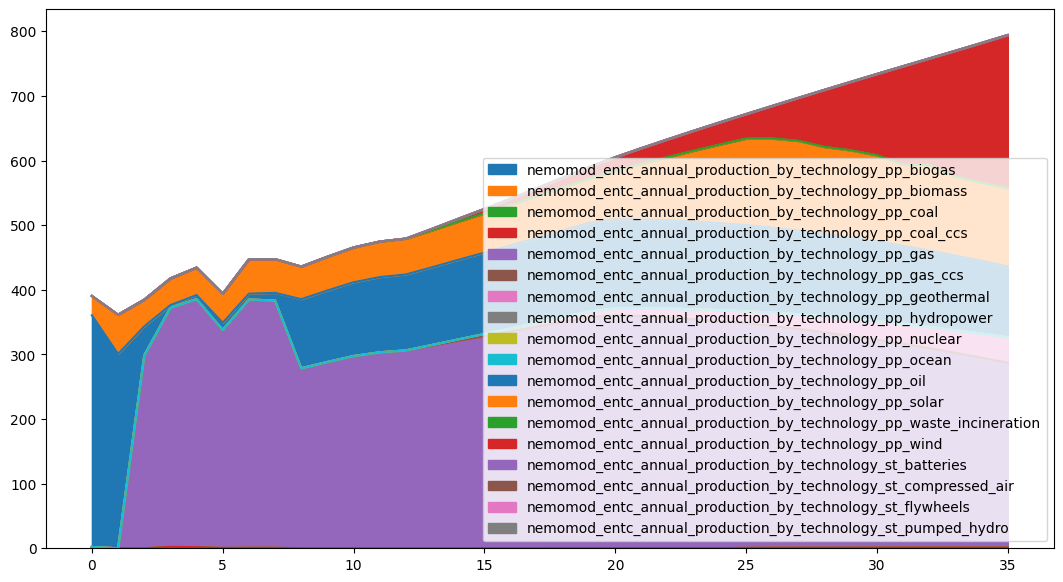

In [52]:
_MODVAR_ENTC_PBT = matt.get_variable("NemoMod Production by Technology")

fig, ax = plt.subplots(figsize = (13, 7))
_MODVAR_ENTC_PBT.get_from_dataframe(df_out).plot.area(ax = ax,)



In [96]:
strat0 = strategies.get_strategy(0)
df0 = strat0()

df_out = models(
    df0, 
    include_electricity_in_energy = True, 
    time_periods_base = range(11),
    time_periods_run = range(11),
)

2025-03-Nov 20:25:11.993 Opened SQLite database at /Users/usuario/git/sisepuede_region_nbs/morocco/tmp0ndssv7r.sqlite.
2025-03-Nov 20:25:12.002 Added NEMO structure to SQLite database at /Users/usuario/git/sisepuede_region_nbs/morocco/tmp0ndssv7r.sqlite.
2025-03-Nov 20:25:12.792 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-03-Nov 20:25:12.836 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010].
2025-03-Nov 20:25:22.414 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


In [93]:
um_energy = matt.get_unit("energy")
total_elec = 33746*um_energy.convert("mwh", "pj")*1000
total_elec[]

121.4856

In [112]:
df_out[[x for x in df_out.columns if ("nemomod_entc_annual_production_by_technology" in x)]].iloc[0]

nemomod_entc_annual_production_by_technology_pp_biogas                  0.000000
nemomod_entc_annual_production_by_technology_pp_biomass                 2.085346
nemomod_entc_annual_production_by_technology_pp_coal                    0.000000
nemomod_entc_annual_production_by_technology_pp_coal_ccs                0.000000
nemomod_entc_annual_production_by_technology_pp_gas                     0.000000
nemomod_entc_annual_production_by_technology_pp_gas_ccs                 0.000000
nemomod_entc_annual_production_by_technology_pp_geothermal              0.000000
nemomod_entc_annual_production_by_technology_pp_hydropower              0.000000
nemomod_entc_annual_production_by_technology_pp_nuclear                 0.000000
nemomod_entc_annual_production_by_technology_pp_ocean                   0.000000
nemomod_entc_annual_production_by_technology_pp_oil                   358.476893
nemomod_entc_annual_production_by_technology_pp_solar                  29.886394
nemomod_entc_annual_producti

In [118]:
#df0[[x for x in df0.columns if "" in x]].iloc[0]
df_libya[[x for x in df_libya.columns if "residual_capaci" in x]].iloc[8]
df0[[x for x in df0.columns if "residual" in x]].iloc[0]

# 



(0.06506923890063424, 0.9349307610993657)

In [287]:
_ATTR_LVST = matt.get_attribute_table(matt.subsec_name_lvst, )
_CATS = ["cattle_dairy", "cattle_nondairy", "goats", "sheep"]
_INDS = [_ATTR_LVST.get_key_value_index(x) for x in _ATTR_LVST.key_values if x in _CATS]

# model variables
_MODVAR_LVST_CCS = matt.get_variable("Carrying Capacity Scalar")
_MODVAR_LVST_DMC = matt.get_variable(models.model_afolu.modvar_lvst_dry_matter_consumption)
_MODVAR_LVST_POP_INIT = matt.get_variable("Initial Livestock Head Count")
_MODVAR_LVST_POP = matt.get_variable("Livestock Head Count")

# get arrays--init pop (incl hist)
arr_init = _MODVAR_LVST_POP_INIT.get_from_dataframe(
    df_libya,
    return_type = "array"
)
_MODVAR_LVST_DMC = matt.get_variable(models.model_afolu.modvar_lvst_dry_matter_consumption)

# get projected pop
arr_proj = _MODVAR_LVST_POP.get_from_dataframe(
    df_out,
    return_type = "array",
)

# get est of total consumed dry matter
arr_dmc = _MODVAR_LVST_DMC.get_from_dataframe(
    df_libya,
    return_type = "array",
)
arr_dmc_init = arr_dmc*arr_init
arr_dmc_proj = arr_dmc*arr_proj

vec_scale = np.nan_to_num(
    arr_dmc_init.sum(axis = 1)/arr_dmc_proj.sum(axis = 1),
    nan = 0.0
)


# get inds to use for projecting
vec_pop_total = arr_init.sum(axis = 1, )
for i, val in enumerate(vec_pop_total):
    if i == len(vec_pop_total) - 1: continue

    if vec_pop_total[i + 1] == val: break


vec_scale_red = vec_scale[0:i]
targ_next = sf.project_from_array(
    vec_scale_red[..., None],
    max_deviation_from_mean = 0.5,
)

vec_cc = targ_next*np.ones(df_libya.shape[0])
vec_cc[0:vec_scale_red.shape[0]] = vec_scale_red

# UPDATE
df_libya[_MODVAR_LVST_CCS.fields[0]] = vec_cc

# update here
"""

df_try = models(
    df_libya, 
    include_electricity_in_energy = False, 
    time_periods_base = range(11),
    time_periods_run = range(11),
)


# update fertilizer quickly
# use 20kg/ha, which is a rough approximation from here: https://data.worldbank.org/indicator/AG.CON.FERT.ZS?locations=LY
df_try[[x for x in df_try.columns if "area_lndu" in x and ("conversion" not in x)]]
df_try["area_lndu_croplands"].iloc[0]*20/1000000 # thjis came to 34.173693884797274


"""
df_libya["qtyinit_soil_synthetic_fertilizer_kt"] = 34.174


<function sisepuede.utilities._toolbox.project_from_array(arr_in: numpy.ndarray, max_deviation_from_mean: Optional[float] = 0.2, max_lookback: Optional[int] = None) -> Optional[numpy.ndarray]>

In [362]:
df_libya_ow = df_libya[[
    time_periods.field_time_period,
    "qtyinit_soil_synthetic_fertilizer_kt",
    _MODVAR_LVST_CCS.fields[0]
]]

sf._write_csv(
    df_libya_ow,
    "/Users/usuario/Desktop/libya_var_overwrites.csv",
)

True

In [357]:
df_try = models(
    df_libya, 
    include_electricity_in_energy = False, 
    time_periods_base = range(11),
    time_periods_run = range(11),
)

(<Figure size 1800x1200 with 1 Axes>, <Axes: >)

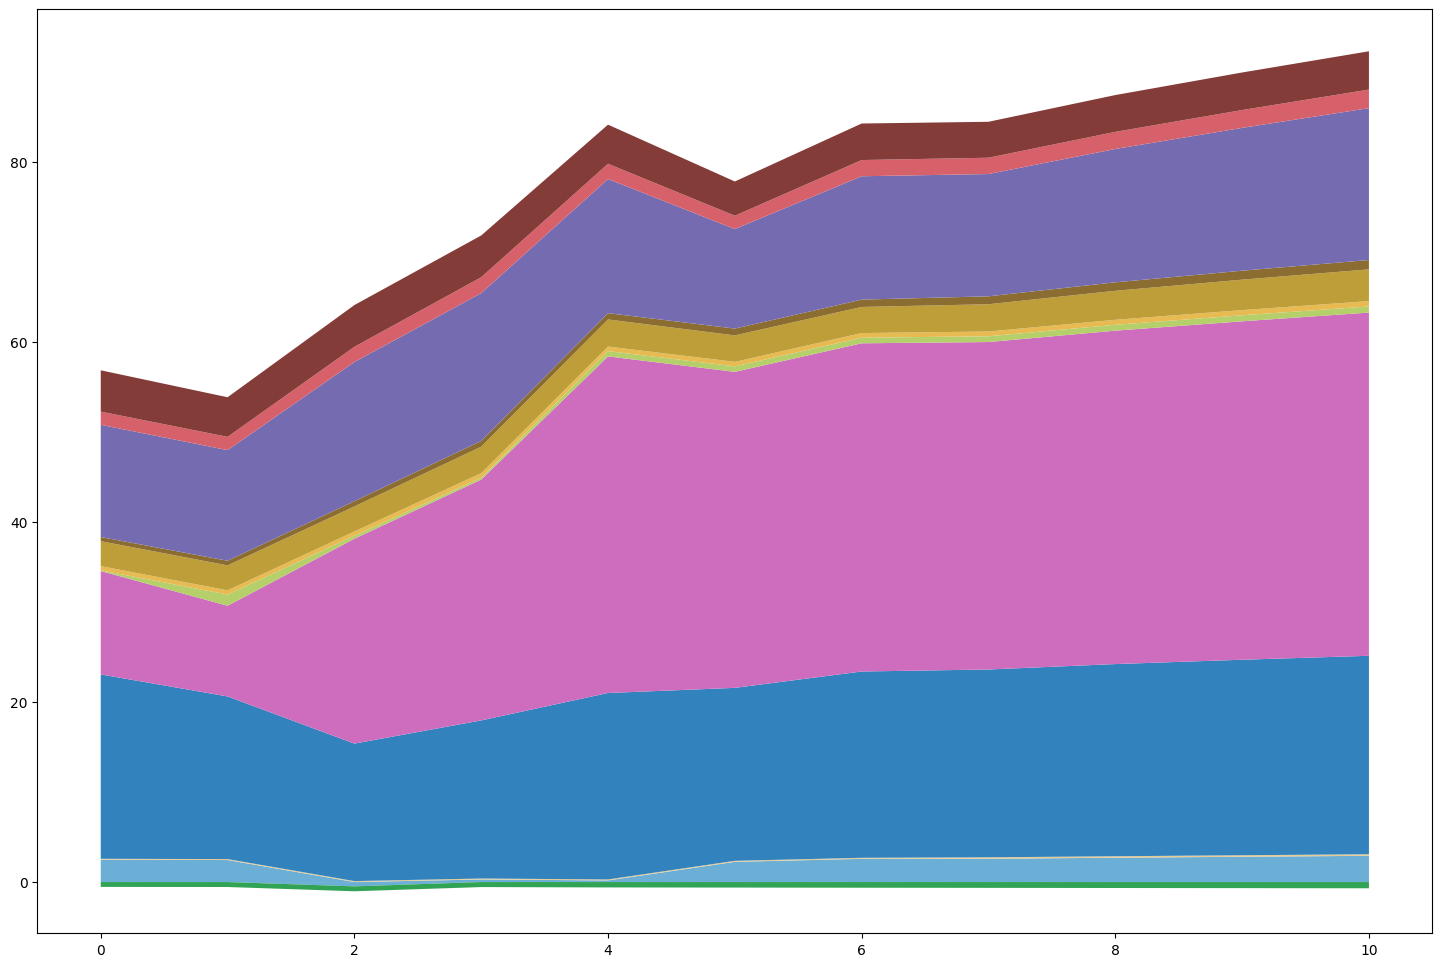

In [358]:
svp.plot_emissions_stack(df_try, matt, )

<Axes: >

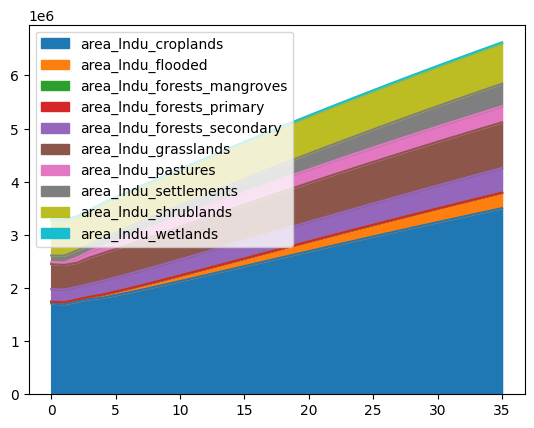

In [242]:
modvar = matt.get_variable("Land Use Area")
flds = [x for x in modvar.fields if "other" not in x]

df_out[flds].plot.area()

In [214]:


##  adjust min share production--we need to get better values for this data
modvar_msp = matt.get_variable(models.model_enerprod.modvar_entc_nemomod_min_share_production)

# shares based from resid cap
share_ng = 8.844445
share_oil = 0.615555
total = share_oil + share_ng

# update fields
field_pp_gas = modvar_msp.build_fields(category_restrictions = "pp_gas", )
field_pp_oil = modvar_msp.build_fields(category_restrictions = "pp_oil", )

dict_new = {
    field_pp_gas: share_ng/total,
    field_pp_oil: share_oil/total, 
}

df_libya[modvar_msp.fields] = 0
for k, v in dict_new.items():
    df_libya[k] = v


# increase gas effic
df_libya["efficfactor_entc_technology_fuel_use_pp_gas"] = 0.55

# adjust exports a bit
# exports from https://www.iea.org/countries/libya/natural-gas
vec_exp = [
    243.162,
    164.159,
    157.319,
    153.899,
    194.940,
    153.899,
    110.466,
    88.919,
    86.184
]
vec_new = np.zeros(df_libya.shape[0], )
vec_new[0:len(vec_exp)] = np.array(np.array(vec_exp))
vec_new[len(vec_exp):] = vec_exp[-1]
df_libya["exports_enfu_pj_fuel_natural_gas"] = vec_new


In [215]:
df_out = models(
    df_libya, 
    time_periods_base = range(11), 
)

2025-03-Nov 22:14:11.751 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-03-Nov 22:14:11.815 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010].
2025-03-Nov 22:14:23.260 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010].
2025-03-Nov 22:14:23.291 Started optimizing following years: [1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-03-Nov 22:15:30.707 Finished optimizing following years: [1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


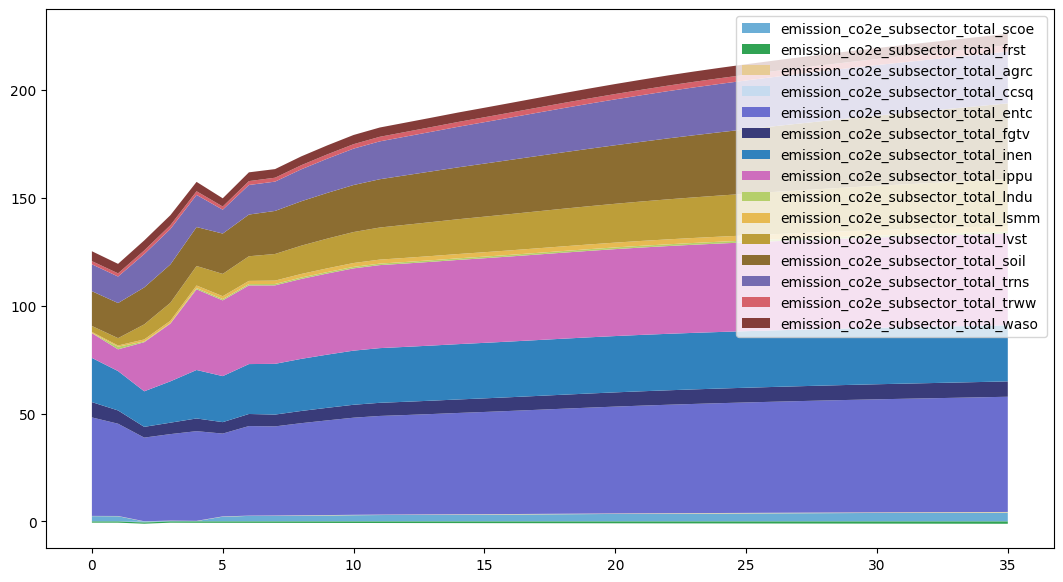

In [224]:
fig, ax = plt.subplots(figsize = (13, 7))
svp.plot_emissions_stack(df_out, matt, figtuple = (fig, ax, ))
ax.legend(loc = "upper right")

In [229]:
df_out[[x for x in df_out.columns if "emission_co2e" in x and "soil" in x]].iloc[0]

emission_co2e_co2_lndu_drained_organic_soils_croplands     0.000000
emission_co2e_co2_lndu_drained_organic_soils_pastures      0.000000
emission_co2e_co2_soil_lime_use                            0.011205
emission_co2e_co2_soil_soc_mineral_soils                   0.013665
emission_co2e_co2_soil_urea_use                            1.392307
emission_co2e_n2o_soil_fertilizer                         14.537475
emission_co2e_n2o_soil_mineral_soils                       0.000160
emission_co2e_n2o_soil_organic_soils                       0.003465
emission_co2e_n2o_soil_paddock_pasture_range               0.170057
emission_co2e_subsector_total_soil                        16.128334
Name: 0, dtype: float64

In [172]:
import sisepuede.utilities._sql as squ
import sqlalchemy


In [175]:
engine = str(path_cur.joinpath("tmp0ndssv7r.sqlite"))
engine = sqlalchemy.create_engine(f"sqlite:///{engine}")

In [190]:
tab = squ.sql_table_to_df(engine, "vusebytechnologyannual")

In [196]:
tab[
    tab["f"].isin(["fuel_natural_gas"])
    & tab["y"].isin(["1000"])
]

,r,t,f,y,val,solvedtm
95,costa_rica,me_coal,fuel_natural_gas,1000,0.249571,2025-11-03 21:47:59.193
237,costa_rica,pp_gas,fuel_natural_gas,1000,1201.636486,2025-11-03 21:47:59.193


In [197]:
tab_prod = squ.sql_table_to_df(engine, "vproductionbytechnologyannual")

In [198]:
tab_prod[
    tab_prod["f"].isin(["fuel_electricity"])
    & tab_prod["y"].isin(["1000"])
]

,r,t,f,y,val,solvedtm
8,costa_rica,pp_solar,fuel_electricity,1000,5.827259e-13,2025-11-03 21:47:59.193
171,costa_rica,pp_gas,fuel_electricity,1000,4.806546e+02,2025-11-03 21:47:59.193
255,costa_rica,pp_oil,fuel_electricity,1000,3.345256e+01,2025-11-03 21:47:59.193


In [199]:

tab_iar = squ.sql_table_to_df(engine, "InputActivityRatio")
tab_iar[
    tab_iar["t"].isin(["pp_gas"])
    & tab_iar["y"].isin(["1000"])
]


,id,r,t,f,m,y,val
972,973,costa_rica,pp_gas,fuel_natural_gas,generate,1000,2.5
